# 1. Supervised Learning
>Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the feature\_importances\_ attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature\_importances\_ attribute?

> *BONUS:* plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?

From the preprocessing step, we generated 6 datasets, that we will use with our machine learning algorithm. We will later on compare the results we obtain. As a reminder, the 6 datasets are as follows
1.  3 datasets with NaNs and 3 without NaNs

2.  1. players.csv -> Simply the players, no added cross-features
    2. players_with features.csv -> Added cross-features.
    3. players_with features_only_num_values.csv -> We do not consider the textual fields.
    
    
## 1.0. Imports

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, learning_curve
import sklearn.metrics
%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

## 1.1. Preparing the features
Given a file, loads the features the way we need them to pass them to the `RandomForestClassifier` method. We first create a field named *X* which contains all the features (entries of the loaded DataFrame minus the *skin_colour* column of it). The *Y* will will be the output labels, containing the informations of the *skin_colour* columns DataFrame, but the values will be rescaled into integers. Finally, the *columns* fields contains the name of the features of *X*.


We also prepare the output labels : first of all, we do a binary classification, setting the limit at a *threshold* which is by default fixed at *0.5*, in order to have a simple case to treat. We return as well the columns vector, which corresponds to the features we're dealing with.

In [2]:
def prepare_features_binary(file_,thresh = 0.5):
    """
        Loads the data contained in the file_ and formats it in the way we need for it to be fed into a sklearn classifier. 
        @param file_ : the file which contains the data we want to learn on.
        @param thresh : the threshold at which we set the binary classification (x >= thresh -> y = 1, x < thresh -> y =0)
        @return X : the features of the model (size n_samples x n_features)
        @return Y : the labels of our set (size n_samples)
        @return columns : the name of the features (list of string of size n_features)
    """
    df = pd.read_csv(file_)

    # We drop the skin colour as it is the solution, it goes into the output array.
    X = df.drop('skin_colour',axis=1)
    
    columns = X.columns.values
    
    Y = np.array(df['skin_colour'])
    
    # Binary classification performed here.
    Y = (Y>=thresh).astype(int)
    
    return X, Y, columns

The second preparation splits the data into a given number of classes, in order to see how we perform which less aggregated data. It outputs a label from *0* to *split* for the *Y* attribute. 

An example is worth a thousand words. Our data *Y* are takes values in one of those : 
$y_i \in [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]$

Let us suppose our Y has the form  $Y = [0, 0.25, 0.5, 0.5, 0.75, 1, 0.625]$
Hence, aggregating our data in 3 classes will yield the the Y's to go into 
- The class labelled 0 if $y_i \in [0, 0.125, 0.25] $
- The class labelled 1 if $y_i \in [0.375, 0.5, 0.625]$
- The class labelled 2 if $y_i \in [0.75, 0.875, 1]$

Thus, our example will end up being of the form $Y_{agg} = [0, 0, 1, 1, 2, 2, 1]$. This is what the routine `prepare_features_multi` does.

In [3]:
def prepare_features_multi(file_,split):
    """
        Loads the data contained in the file_ and formats it in the way we need for it to be fed into a sklearn classifier.
        The form of the output is the following  : x in the interval [ split[i], split[i+1] [ -> output y = i
        @param file_ : the file which contains the data we want to learn on.
        @param split : the number of different output classes that we will have (2 to 9 classes only)
        @return X : the features of the model (size n_samples x n_features)
        @return Y : the labels of our set (size n_samples)
        @return columns : the name of the features (list of string of size n_features)
    """
    df = pd.read_csv(file_)
    # We drop the skin colour as it is the solution, it goes into the output array.
    X = df.drop('skin_colour',axis=1)
    columns = X.columns.values
    
    
    Y = np.array(df['skin_colour'])
    #Array which contains the values at which we classify into a category or the next one
    splits = np.linspace(0,1,split+1)
    
    #Array which starts at a basis negative (invalid value) and contains the labels of which of the 
    #class in which the data entry is.
    Y_agg = -2*np.ones(len(Y))
    
    for i in range(0, split):
        Y_agg[np.logical_and(Y >= splits[i], Y < splits[i+1])] = i
    Y_agg[Y==1] = i
    
    return X, Y_agg,columns

## 1.2. Classification of our data.
The classifier we were asked to use is the Random Forest. In order to evaluate the performance of our results, we will use several tools, which will help us to understand better the results we obtain. 

1. The [cross_validation module of scikit-learn](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.cross_val_score.html) allows us to test the performance of our classification. The `cross_val_score` method returns the percentage of accuracy of our classification (average of the testing error of each iteration of the cross-validation. The `cv` field allows us to chose the number of folds of cross-validation we want to perform (e.g. cv=5 -> 5-fold cross-validation).
2. The [F1 score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) takes into account the false positives and the false negatives in the process of outputting the score. Hence, a model with a high prediction accuracy can get very poor results in the F1-metric if for instance it outputs everything to an output which is dominant in the population (cf. the examples "Everybody has cancer" in the lecture 07 of the course).
3. [The confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) plots the detail of the classification, and allows us to visualise the false positives, false negatives. We can compute the F1-score from this matrix.
4. The [feature importances](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) allows us to see which of the features are the most significant for the classification. 


If we turn now to the coding, the first function below `print_confusion_matrix` is a helper function that helps us visualising the confusion matrix in a more elegant way than the usual way of displaying a 2D numpy array.

In [4]:
def print_confusion_matrix(conf_matrix):
    """
        Prints in textual way the entries of the confusion matrix conf_matrix and allows us to visualise it in a 
        more elegant way than when displaying it simply with print. It makes the understanding of it more intuitive.
    """
    print('\n\t\t\tDISPLAYING THE CONFUSION MATRIX\n')
    print('\tPredicted : ',end='\t' )
    features = conf_matrix.shape[0]
    for i in range(0,features):
        print(i,end='\t')
    print('TOTAL')
    print('\n Reality : ',end='\t')
    for i in range(0,features):
        print(i,'||',end='\t')
        for j in range(0,features):
            print(conf_matrix[i,j],end='\t')
        print(sum(conf_matrix[i,:]),end='\n\t\t')
    print('\nTOTALS : \t  ||',end='\t')
    for j in range(0,features):
        print(sum(conf_matrix[:,j]),end='\t')
    print(sum(sum(conf_matrix)))

The `cross_validation` function does perform the *cv_param*-fold cross-validation, and outputs the cross-validation result, along with F1-score and the confusion matrix, in order for us to understand the shape of our results. We perform by default a 20-fold cross validation, as we want a result as stable as possible.

In [5]:
def cross_validation(X,Y,cv_param = 20, max_depth = None): 
    """
        Cross_validation takes as input a dataset X and the labels Y and performs the cv_param-fold cross validation.
        It uses a random forest classifier in order to do so and plots the cross-validation score, the f1-score
        as well as the confusion matrix.
    """
    # 1. Creates the classifier that we will use 
    forest = RandomForestClassifier(max_depth = max_depth)
    # 2. Predicts the output of the classification after cv_param-fold cross-validation
    Y_predicted = cross_val_predict(forest, X, Y, cv=cv_param)
    
    # 3. Print the results : scores, 
    print('Cross Validation result :', cross_val_score(forest,X,Y,cv = cv_param).mean(),
        '\nF1 score result :',sklearn.metrics.f1_score(Y, Y_predicted,average='micro'))
    
    print_confusion_matrix(sklearn.metrics.confusion_matrix(Y,Y_predicted))

The `plot_feature_importances` function does rank each feature of *X* accordingly to the role it plays into the classification of the data we give it. This allows us to see whether a key subset of our features would turn out to be outstandingly better than the rest at determining the skin colour of a player.

In [6]:
def plot_feature_importances(X, Y, columns,plot_flag = 1, max_depth = None):
    """
        plot_feature_importances displays the importance of each feature into determining the output of our problem. 
        @param plot_flag : a boolean which can be turned on or off for the plotting for the display of the results.
    """
    forest = RandomForestClassifier(max_depth = max_depth)
    forest = forest.fit(X,Y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")

    if(plot_flag):    
        for f in range(X.shape[1]):
            print("%d. feature %d - %s (%f)" % (f + 1, indices[f],  columns[indices[f]], importances[indices[f]]))
            
        # Plot the feature importances of the forest
        plt.figure()
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    return indices,importances

# 1.3. Bonus part 
> *BONUS:* plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?

It turns out that the learning curves are useful to be able to see whether our model is massively overfitting, and to help tune the best parameters on which to run our model. We will then plot the learning curves here and will pick the best model we have for the rest of the exercise. 

We will load different data and compare the learning curves on them. We consider 3 different number of classes : 2, 5 and 9 classes of skin colour, in which we classify the players. We load also two different datasets : the first where where did not add any features, and a second one with the featuers we added).

In [7]:
# Data without features, classified into 2-5-9 classes
X_no_ft_binary,Y_no_ft_binary,columns_no_ft_binary = prepare_features_multi('Data/players_no_nan_only_num_values.csv',2)
X_no_ft_5,Y_no_ft_5,columns_no_ft_5 = prepare_features_multi('Data/players_no_nan_only_num_values.csv',5)
X_no_ft_9,Y_no_ft_9,columns_no_ft_9 = prepare_features_multi('Data/players_no_nan_only_num_values.csv',9)

# Data with features added, classified into 2-5-9 classes.
X_2, Y_2, columns_2 = prepare_features_multi('Data/players_with features_no_nan_only_num_values.csv',2)
X_5, Y_5, columns_5 = prepare_features_multi('Data/players_with features_no_nan_only_num_values.csv',5)
X_9 ,Y_9, columns_9 = prepare_features_multi('Data/players_with features_no_nan_only_num_values.csv',9)

To the extent of plotting the learning curves, we will use the [learning_curve function of scikit learn](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html). As asked in the exercise, we perform split our data in 20 folds and will also perform a 20-fold cross validation each time, as we did throughout the rest of the exercise. The function that plots the learning curves was *largely* taken from [this example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py) on the scikit learn website. 

The first result that we plot is the learning curves using the very basic *Random Forest Classifier*, without any argument passed. It means that, for instance, the maximal depth of the tree is not fixed.

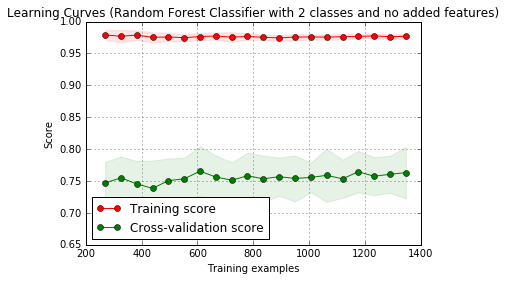

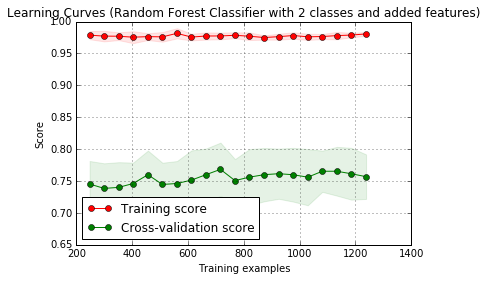

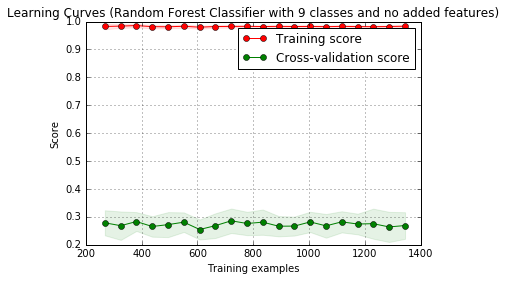

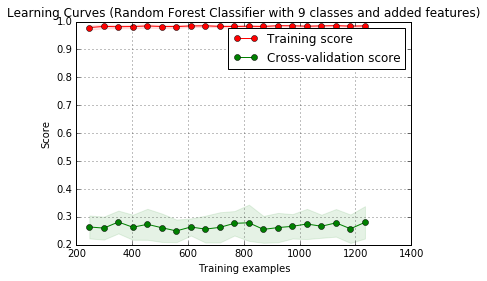

In [8]:
def plot_learning_curve(estimator,X,Y,title,cv=20):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, Y, cv=cv, train_sizes=np.linspace(0.2,1,20))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

    
estimator = RandomForestClassifier()    

title = "Learning Curves (Random Forest Classifier with 2 classes and no added features)"
plot_learning_curve(estimator,X_no_ft_binary,Y_no_ft_binary,title,20)   

title = "Learning Curves (Random Forest Classifier with 2 classes and added features)"
plot_learning_curve(estimator,X_2,Y_2,title,20)    
    
    
title = "Learning Curves (Random Forest Classifier with 9 classes and no added features)"    
plot_learning_curve(estimator,X_no_ft_9,Y_no_ft_9,title,20)

title = "Learning Curves (Random Forest Classifier with 9 classes and added features)"
plot_learning_curve(estimator,X_9,Y_9,title,20)

The 4 plots describes the classification into binary output and 9-classes output respectively, with and without features. They all have the very obvious same problem. The default *RandomForestClassifier* method clearly overfits our data, this is notably due to the fact of having an unfixed depth for the depth of the tree. This is why we will iterate over different depth and fix it to a value that yields a good result, and the fact of having a max depth will mitigate overfitting.

We now compute the result of the cross validation given a certain depth, varying from 1 to 20. Do not look too much at the `plot_fig` function, which only provides visulisation of our data obtained while iterating on the max_depth of the forest.

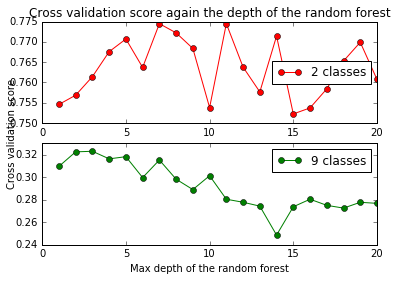

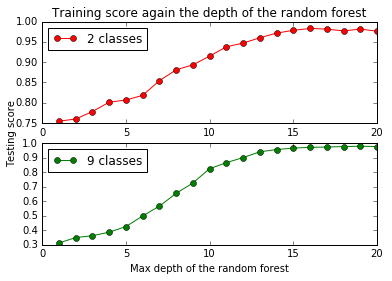

In [9]:
cv_score_2 = np.zeros(20)
cv_score_9 = np.zeros(20)

tr_score_2 = np.zeros(20)
tr_score_9 = np.zeros(20)

cv_param = 20
for i in range(1,21):
    forest = RandomForestClassifier(max_depth = i)
    cv_score_2[i-1] = cross_val_score(forest,X_2,Y_2,cv = cv_param).mean()
    cv_score_9[i-1] = cross_val_score(forest,X_9,Y_9,cv = cv_param).mean()
    forest.fit(X_2,Y_2)
    tr_score_2[i-1] = forest.score(X_2,Y_2)
    forest.fit(X_9,Y_9)
    tr_score_9[i-1] = forest.score(X_9,Y_9)

def plot_fig(data_1,data_2,title_,xlabel_,ylabel_):
    """
        Custom plotting routine to plot our data the way we want 
        (does not provide anything extremely useful)
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)    # The big subplot
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    # Turn off axis lines and ticks of the big subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

    ax1.plot(np.linspace(1,20,20), data_1, 'o-', color="r",label="2 classes")
    ax2.plot(np.linspace(1,20,20), data_2, 'o-', color="g",label="9 classes")
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    ax.set_title(title_)
    ax.set_xlabel(xlabel_)
    ax.set_ylabel(ylabel_)
    plt.show()

plot_fig(cv_score_2,cv_score_9,
         "Cross validation score against the depth of the random forest",
         "Max depth of the random forest","Cross validation score")    
plot_fig(tr_score_2,tr_score_9,"Training score against the depth of the random forest",
        "Max depth of the random forest","Testing score")

We see that for each of the cases, the accuracy of the precision does not change very much, even if the overfitting is very different. We also want to see which of the depth minimizes the overfitting (i.e. gets the lowest accuracy on the training set). The one we chose is the *max_depth = 7*, which we plot below for the data with added features. We took this entry as it is a good compromise between a good cross-validation score and a low testing score, which means no overfitting.

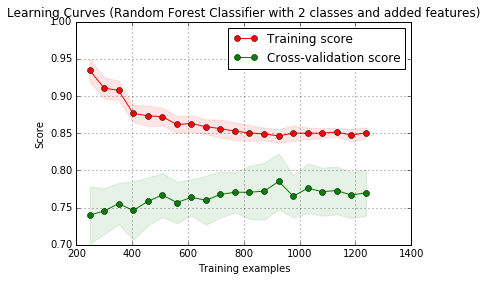

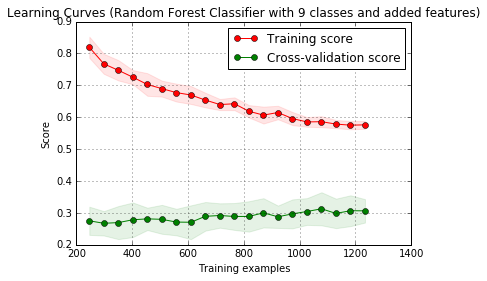

In [10]:
estimator = RandomForestClassifier(max_depth = 7)    

title = "Learning Curves (Random Forest Classifier with 2 classes and added features)"
plot_learning_curve(estimator,X_2,Y_2,title,20)    

title = "Learning Curves (Random Forest Classifier with 9 classes and added features)"
plot_learning_curve(estimator,X_9,Y_9,title,20)

The results that we get in this case are way more reassuring than those we got without fixing the maximal depth of the tree, without decresing the accuracy of the cross-validation score. It means that for data that our algorithm did not train on before, it will perform better than its counterpart without fixed depth, as it tends less to overfit.

## 1.4. Comparison of the results for different models.
Having found the depth at wich our tree does not overfit, we want to focus on understanding the results we get. We will compare again the raw data, taking only the numeric values of the basic features we were given and adding the country in which the player is currently playing as fields as well along with, in a second time, the features we added. We will iterate over different splits (i.e. binary classification, 5 classes, and 9 classes) and see the feature importances evolution with the number of classes we have for the classification. 

In [11]:
#Binary classification
print('STARTING WITH BINARY CLASSIFICATION\n')
cross_validation(X_no_ft_binary, Y_no_ft_binary, cv_param=20, max_depth=7)

STARTING WITH BINARY CLASSIFICATION

Cross Validation result : 0.772442432372 
F1 score result : 0.7681465821

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	TOTAL

 Reality : 	0 ||	1057	32	1089
		1 ||	297	33	330
		
TOTALS : 	  ||	1354	65	1419


Starting with the raw features and the binary classification, one can immediately that there is a huge problem ! The first problem comes from the data themselves, splitting in two groups of people at a threshold of 0.5, we get two very inegal groups. One with output 1 (white) contains 1089 entries, while the second one (coloured) contains 330 entries only. There is a quite large imbalance here. We get roughly 75% of the population in the first class, and only 25% percent in the second one.


The classification, which actually got an accuracy of 75% is quite wrong, as it nearly classifies all the entries as 0, which gives 75% percent accuracy, as 75% percent of the population is in his class. We see that the problem lies in the fact that for the class 1, nearly all its entries (292 people), are wrongly classified as belonging to the class 0, while only 40 are correctly classified ! Only 5% of the members of the class with label 1 are classified correctly, against 98% of the members of the class 0. We hence see that our model with the raw features is not a good classifier. We will try later on to change the threshold to have a more balanced number of persons in each class for the binary classification to see whether the performance improves.

Now, we will preform the 5/9-classes classification, and see how the prediction evolves.

In [12]:
#5 classes classification
print('\n5 CLASSES CLASSIFICATION\n')
cross_validation(X_no_ft_5, Y_no_ft_5, cv_param=20, max_depth=7)


5 CLASSES CLASSIFICATION

Cross Validation result : 0.450922743825 
F1 score result : 0.450317124736

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	2	3	4	TOTAL

 Reality : 	0 ||	414	175	0	2	5	596
		1 ||	261	220	3	1	8	493
		2 ||	60	41	0	0	2	103
		3 ||	65	39	0	2	7	113
		4 ||	63	43	0	5	3	114
		
TOTALS : 	  ||	863	518	3	10	25	1419


The results shows an accuracy of 46%, confirmed by the F1-metric score. The problem that shows here is exactly the same as before. The classes with a lot of entries (class with label 0 and 1 (i.e. skin_colour from 0 to 0.4) get almost all the entries : 1383 out of 1419 entries, while "only" containing in reality 1089 entries. We get 26% people more than there should be in these classes, with only actually 59% percent of the people correctly classified. And the problems shows that nearly all the people from the smaller classes (resp. 103,113,114 entries) are very much missclassified, with only in total 10% of people that we should have across those 3 classes, and only 7 people classified correctly across those 3 classes (which represents 2% of the entries) ! Another problem also arises here, it is the fact that a lot of people of the class 0 are wrongly classificated in the class 1, and a lot of people of the class 1 are wrongly classified into the class 0, yielding a very large error as well. 

If we now turn to the 9 classes classification, we would expect to get the same behaviour as here, only with more "extreme" cases.

In [13]:
#9 classes classification
print('\n9 CLASSES CLASSIFICATION\n')
forest_no_ft = cross_validation(X_no_ft_9, Y_no_ft_9, cv_param=20, max_depth=7)


9 CLASSES CLASSIFICATION

Cross Validation result : 0.324309778507 
F1 score result : 0.338266384778

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	2	3	4	5	6	7	8	TOTAL

 Reality : 	0 ||	213	10	157	0	0	0	1	0	5	386
		1 ||	104	10	94	1	0	0	1	0	0	210
		2 ||	133	10	257	4	3	1	2	2	7	419
		3 ||	25	2	45	0	1	0	1	0	0	74
		4 ||	42	4	53	0	0	0	3	1	0	103
		5 ||	8	2	17	0	1	0	0	0	0	28
		6 ||	26	0	54	0	1	0	0	4	0	85
		7 ||	9	1	20	0	1	0	1	0	2	34
		8 ||	30	2	43	0	1	0	4	0	0	80
		
TOTALS : 	  ||	590	41	740	5	8	1	13	7	14	1419


We see that our results again are in the same fasion as before : the classes with a lot of entries (here the classes 0 and 2) get a lot of entries, and actually a lot more than they should (613 and 725 against 386 and 419 resp.). The error of classification is again huge and is due a lot to the fact that roughly half of the entries of the class 0 are classified into class 2 and inversely ! The classifier does not do at all any difference between both entries. There is also another case of interest in the fact that the 0 elements gets classified into class 5, while there are actually 28 elements in it ! It shows that having only the basic features is clearly not suffificent for our model to be able to classify the players in a reliable manner. 

Let us now turn to the feature importances and try to see whether some feature stands out in every case.


2 CLASSES CLASSIFICATION

Feature ranking:
1. feature 3 - victories (0.097381)
2. feature 4 - ties (0.094027)
3. feature 5 - defeats (0.092218)
4. feature 1 - weight (0.085303)
5. feature 2 - games (0.084223)
6. feature 6 - goals (0.074052)
7. feature 12 - french (0.071101)
8. feature 11 - german (0.069204)
9. feature 14 - birthYear (0.065226)
10. feature 7 - yellowCards (0.064824)
11. feature 0 - height (0.054682)
12. feature 9 - redCards (0.046996)
13. feature 10 - english (0.039809)
14. feature 13 - spanish (0.034905)
15. feature 8 - yellowReds (0.026048)


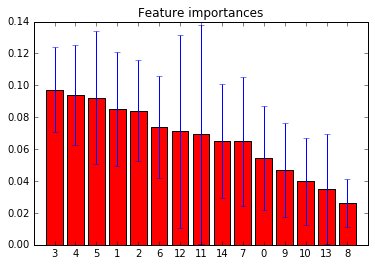


5 CLASSES CLASSIFICATION

Feature ranking:
1. feature 3 - victories (0.097296)
2. feature 5 - defeats (0.096727)
3. feature 4 - ties (0.094643)
4. feature 1 - weight (0.087526)
5. feature 14 - birthYear (0.085465)
6. feature 0 - height (0.084480)
7. feature 6 - goals (0.080260)
8. feature 7 - yellowCards (0.076650)
9. feature 2 - games (0.075227)
10. feature 12 - french (0.068182)
11. feature 9 - redCards (0.048523)
12. feature 13 - spanish (0.029674)
13. feature 10 - english (0.025587)
14. feature 8 - yellowReds (0.025118)
15. feature 11 - german (0.024640)


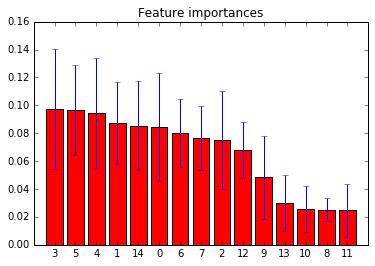


9 CLASSES CLASSIFICATION

Feature ranking:
1. feature 3 - victories (0.100720)
2. feature 7 - yellowCards (0.100599)
3. feature 14 - birthYear (0.097545)
4. feature 4 - ties (0.092843)
5. feature 0 - height (0.091098)
6. feature 2 - games (0.088422)
7. feature 6 - goals (0.084419)
8. feature 1 - weight (0.076972)
9. feature 5 - defeats (0.076678)
10. feature 11 - german (0.045778)
11. feature 8 - yellowReds (0.040214)
12. feature 12 - french (0.031293)
13. feature 9 - redCards (0.030827)
14. feature 13 - spanish (0.022087)
15. feature 10 - english (0.020505)


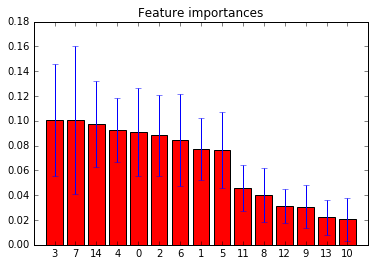

In [23]:
print('\n2 CLASSES CLASSIFICATION\n')

features_2 = plot_feature_importances(X_no_ft_binary,Y_no_ft_binary,columns_no_ft_binary, max_depth=7)
print('\n5 CLASSES CLASSIFICATION\n')

features_5 = plot_feature_importances(X_no_ft_5, Y_no_ft_5, columns_no_ft_5, max_depth=7)
print('\n9 CLASSES CLASSIFICATION\n')

features_9 = plot_feature_importances(X_no_ft_9, Y_no_ft_9,columns_no_ft_9, max_depth=7)

There is a lot to say from these feature importances. Namely, the trends are the same for the three models, with a different number of classes. This shows that even if our results are not good, they are produced from the model with a consistent approach, and are maybe due to the fact that it is actually impossible to reliably predict the colour of the skin of a player from the features we considered here. 

On the results we just saw, one can clearly see that none of the features appears to be particularly significant : a few of them lie just around 10% of importance, 2-3 are intermediate and 3-4 are not useful. The ranking is as follows :

- **Most useful features :**  games, yellowCards, goals, defeats, ties , victories, weight, birthYear, height 
- **Intermediate :** yellowReds, redCards, (french)
- **Not useful :** (french), spanish, german, english

It is interesting to constast that those results are consistent throughout the different runs. The *french* feature, which means the player is playing in France, seems to be just slightly more efficient in the binary classification, for an unknown reason. If one looks at those features, it seems indeed hard to determine the skin colour of a player from those data, as none of those features seem efficient in doing the difference. We will now try to redo the same pipeline, but with the features we created, which are linked to the bias of the referee towards the skin colour of the player, and we'll see if we obtain better results.

Let us again first prepare our features, then cross-validate them and see the feature importances.

In [15]:
#2 classes classification

print('\n\nRESULTS WITH NO FEATURES ADDED\n')
cross_validation(X_no_ft_binary, Y_no_ft_binary, cv_param=20, max_depth=7)

print('\n2 CLASSES CLASSIFICATION\n')
cross_validation(X_2, Y_2, cv_param=20, max_depth=7)




RESULTS WITH NO FEATURES ADDED

Cross Validation result : 0.770250391236 
F1 score result : 0.764622973925

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	TOTAL

 Reality : 	0 ||	1053	36	1089
		1 ||	298	32	330
		
TOTALS : 	  ||	1351	68	1419

2 CLASSES CLASSIFICATION

Cross Validation result : 0.77372960373 
F1 score result : 0.773006134969

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	TOTAL

 Reality : 	0 ||	958	26	984
		1 ||	270	50	320
		
TOTALS : 	  ||	1228	76	1304


We almost get the same result as before for the binary classification ! Just around 20 elements difference in the total, and 10-20 classification changing across the bord. It seems that the features we worked hard to implement do not bring an improvement to our results, at least for binary classification :(

In [16]:
#5 classes classification
print('\n\nRESULTS WITH NO FEATURES ADDED\n')
cross_validation(X_no_ft_5, Y_no_ft_5, cv_param=20, max_depth=7)

print('\n5 CLASSES CLASSIFICATION\n')
cross_validation(X_5, Y_5, cv_param=20, max_depth=7)




RESULTS WITH NO FEATURES ADDED

Cross Validation result : 0.445989602015 
F1 score result : 0.448907681466

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	2	3	4	TOTAL

 Reality : 	0 ||	420	168	2	3	3	596
		1 ||	272	209	0	5	7	493
		2 ||	63	36	0	0	4	103
		3 ||	64	40	1	2	6	113
		4 ||	70	33	1	4	6	114
		
TOTALS : 	  ||	889	486	4	14	26	1419

5 CLASSES CLASSIFICATION

Cross Validation result : 0.43538196406 
F1 score result : 0.439417177914

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	2	3	4	TOTAL

 Reality : 	0 ||	370	157	0	3	4	534
		1 ||	246	195	1	3	5	450
		2 ||	52	38	0	2	5	97
		3 ||	63	42	0	1	6	112
		4 ||	65	32	1	6	7	111
		
TOTALS : 	  ||	796	464	2	15	27	1304


Considering now the 5-fold classification,  we get to the same conclusion as before. The adding of our features does not seem to change a lot the results, even decreasing their accuracy from 46% to 44%. This seems to suggest than even if we add the bias of the referee into the balance, we still are not able to significantly increase the accuracy of prediction of our model.

In [17]:
#9 classes classification
print('\n\nRESULTS WITH NO FEATURES ADDED\n')
cross_validation(X_no_ft_9, Y_no_ft_9, cv_param=20)


print('\n9 CLASSES CLASSIFICATION\n')
cross_validation(X_9, Y_9, cv_param=20)




RESULTS WITH NO FEATURES ADDED

Cross Validation result : 0.278626389794 
F1 score result : 0.283298097252

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	2	3	4	5	6	7	8	TOTAL

 Reality : 	0 ||	186	44	133	6	6	1	7	0	3	386
		1 ||	99	23	75	5	3	1	3	0	1	210
		2 ||	138	53	186	6	15	1	12	4	4	419
		3 ||	29	10	29	1	2	1	1	1	0	74
		4 ||	41	13	41	1	2	0	3	0	2	103
		5 ||	10	1	10	2	1	0	1	1	2	28
		6 ||	30	7	36	2	3	0	1	2	4	85
		7 ||	10	6	12	0	1	0	2	0	3	34
		8 ||	34	3	28	0	3	0	5	4	3	80
		
TOTALS : 	  ||	577	160	550	23	36	4	35	12	22	1419

9 CLASSES CLASSIFICATION

Cross Validation result : 0.270646482797 
F1 score result : 0.268404907975

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	2	3	4	5	6	7	8	TOTAL

 Reality : 	0 ||	160	38	125	3	9	0	4	1	2	342
		1 ||	87	24	73	3	0	0	2	0	3	192
		2 ||	164	36	151	6	10	1	8	2	5	383
		3 ||	30	9	24	2	1	0	0	1	0	67
		4 ||	41	10	36	0	0	0	5	0	5	97
		5 ||	9	3	8	0	2	0	1	2	2	27
		6 ||	25	8	36	1	7	0	4	2	2	85
		7 ||	9	5	10	0	3	0	4	0	1	32
		8 ||	28	2	34	0	3	0	2	1	9	79
	

Again here, the results follow exactly the same trend than for the 5 classes case. This does not seem that the features we added have the desired effect. Let us just see whether the features importances changed from the features we added.

Let us now visualise the result we'd get when we would not have added the supplementary features.


2 CLASSES CLASSIFICATION

Feature ranking:
1. feature 16 - meanIAT_yellowCards (0.148198)
2. feature 20 - meanExp_yellowCards (0.081933)
3. feature 6 - goals (0.071819)
4. feature 19 - meanIAT_gravity (0.066340)
5. feature 3 - victories (0.049963)
6. feature 23 - meanExp_gravity (0.049649)
7. feature 18 - meanIAT_redCards (0.045693)
8. feature 22 - meanExp_redCards (0.041465)
9. feature 0 - height (0.038571)
10. feature 1 - weight (0.038079)
11. feature 15 - gravity (0.036382)
12. feature 4 - ties (0.036017)
13. feature 7 - yellowCards (0.035902)
14. feature 2 - games (0.034089)
15. feature 5 - defeats (0.034013)
16. feature 12 - french (0.031547)
17. feature 21 - meanExp_yellowReds (0.031090)
18. feature 17 - meanIAT_yellowReds (0.029612)
19. feature 14 - birthYear (0.027519)
20. feature 13 - spanish (0.024394)
21. feature 10 - english (0.017337)
22. feature 11 - german (0.014950)
23. feature 8 - yellowReds (0.008204)
24. feature 9 - redCards (0.007233)


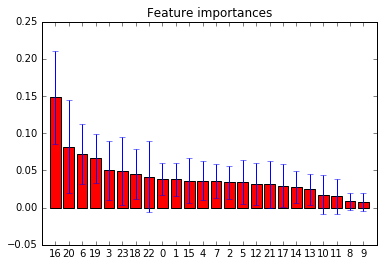


5 CLASSES CLASSIFICATION

Feature ranking:
1. feature 16 - meanIAT_yellowCards (0.086098)
2. feature 19 - meanIAT_gravity (0.070469)
3. feature 14 - birthYear (0.065885)
4. feature 6 - goals (0.062034)
5. feature 20 - meanExp_yellowCards (0.059271)
6. feature 7 - yellowCards (0.058362)
7. feature 2 - games (0.055632)
8. feature 23 - meanExp_gravity (0.054225)
9. feature 3 - victories (0.052888)
10. feature 15 - gravity (0.050707)
11. feature 0 - height (0.045796)
12. feature 22 - meanExp_redCards (0.041319)
13. feature 4 - ties (0.037879)
14. feature 1 - weight (0.034955)
15. feature 5 - defeats (0.033217)
16. feature 18 - meanIAT_redCards (0.031739)
17. feature 12 - french (0.026849)
18. feature 17 - meanIAT_yellowReds (0.025384)
19. feature 21 - meanExp_yellowReds (0.025276)
20. feature 9 - redCards (0.021896)
21. feature 11 - german (0.021023)
22. feature 10 - english (0.013143)
23. feature 13 - spanish (0.013016)
24. feature 8 - yellowReds (0.012939)


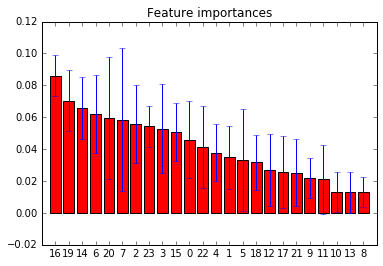


9 CLASSES CLASSIFICATION

Feature ranking:
1. feature 16 - meanIAT_yellowCards (0.099814)
2. feature 20 - meanExp_yellowCards (0.063854)
3. feature 19 - meanIAT_gravity (0.062782)
4. feature 6 - goals (0.062029)
5. feature 23 - meanExp_gravity (0.057947)
6. feature 0 - height (0.056469)
7. feature 1 - weight (0.049727)
8. feature 7 - yellowCards (0.049083)
9. feature 15 - gravity (0.048880)
10. feature 14 - birthYear (0.048141)
11. feature 4 - ties (0.044877)
12. feature 2 - games (0.042533)
13. feature 3 - victories (0.041708)
14. feature 5 - defeats (0.037935)
15. feature 22 - meanExp_redCards (0.037759)
16. feature 21 - meanExp_yellowReds (0.034102)
17. feature 17 - meanIAT_yellowReds (0.031082)
18. feature 11 - german (0.026893)
19. feature 18 - meanIAT_redCards (0.022910)
20. feature 8 - yellowReds (0.021584)
21. feature 12 - french (0.018632)
22. feature 13 - spanish (0.017501)
23. feature 9 - redCards (0.013199)
24. feature 10 - english (0.010558)


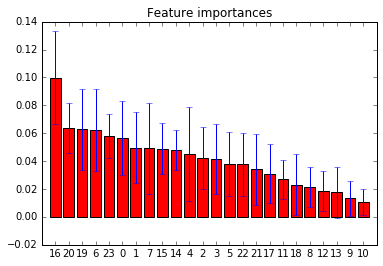

In [24]:
print('\n2 CLASSES CLASSIFICATION\n')
features_2 = plot_feature_importances(X_2,Y_2,columns_2, max_depth = 7)
print('\n5 CLASSES CLASSIFICATION\n')
features_5 = plot_feature_importances(X_5, Y_5, columns_5, max_depth = 7)
print('\n9 CLASSES CLASSIFICATION\n')
features_9 = plot_feature_importances(X_9, Y_9,columns_9, max_depth = 7)

There is not a very clear trend that comes out of the graph, namely that some features are a bit more significant than others, even if their variances are very large. Note that as they are more features, their relative magnitude of importance decreases. We can rank them in the following temptative tiers :


- **Most useful ** : meanExp_yellowCards, games, gravity, meanExp_gravity, goals, defeats, meanIAT_gravity, weight, ties, meanIAT_redCards, meanIAT_yellowCards, height 
- **Somehow useful :** yellowCards,meanExp_yellowReds, meanIAT_yellowReds, victories
- **Not useful : ** german, french, redCards, yellowReds, english, spanish 

Even though none of the features stand out as particularly important, they can be ranked quite consistently. It is interesting to see that the *gravity* feature that we added, along with the *yellowCards* weighted with the *mean_IAT* of the referee are quite useful as features, showing us that skin colour weighted by the bias of the referee helps a *little bit* to get better results, but not in a significantly better manner. The features that were not useful in the previous get still remained not so useful, and the *yellowReds* and *redCards*, even weighted with the *mean_IAT*, still remained useless. It is probably because those events are too rare to really be a consistent behaviour of a referee with respect to a particular skin coloured player. Also, note that the variances are really huge, and the ranking can change a lot from a simulation to another, as a the trees are randomly generated.

## 1.5. Trying to improving our model from the results
The objective now is to simply remove the less meaningful results of our model and see whether the prediction accuracy gets improved from it. The function `prepare_features_multi_remove` keeps only some of the most relevant features, and shows them in the *features* list. Note that the features we have below are a subset of useful features, but might not exactly coincide witht the features ranked above. The idea here is mostly to illustrate the effect of removing some features from the model (*Spoiler alert :* this does not work very well).

In [19]:
 def prepare_features_multi_remove(file_,split):
    features = ['victories','meanIAT_gravity','meanIAT_yellowCards','weight','goals','ties','games','height','meanExp_yellowCards','meanExp_gravity']
    X,Y,columns = prepare_features_multi(file_,split)
    X = X[features]
    
    return X,Y,features


We now quickly go through the 2 and 9 classes cases, in order to spot whether something changed from the removal of the features. Note that we expect the results not to change very much, as the tree was not able to classify correctly the data from this features before, and there should be no reason for it to perform significantly better now that we removed the less meaningful feautres. We would expect at best the results to be obtained slightly faster, as the tree that has to be computed is slightly smaller.


2 CLASSES CLASSIFICATION

Cross Validation result : 0.759195804196 
F1 score result : 0.76763803681

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	TOTAL

 Reality : 	0 ||	931	53	984
		1 ||	250	70	320
		
TOTALS : 	  ||	1181	123	1304

Feature ranking:
1. feature 2 - meanIAT_yellowCards (0.132061)
2. feature 8 - meanExp_yellowCards (0.127011)
3. feature 6 - games (0.117384)
4. feature 9 - meanExp_gravity (0.110363)
5. feature 4 - goals (0.100096)
6. feature 1 - meanIAT_gravity (0.093839)
7. feature 0 - victories (0.093618)
8. feature 3 - weight (0.077877)
9. feature 5 - ties (0.076513)
10. feature 7 - height (0.071239)


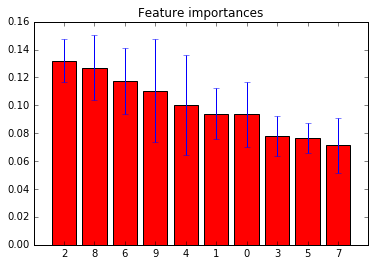


9 CLASSES CLASSIFICATION

Cross Validation result : 0.258430734999 
F1 score result : 0.243865030675

			DISPLAYING THE CONFUSION MATRIX

	Predicted : 	0	1	2	3	4	5	6	7	8	TOTAL

 Reality : 	0 ||	136	51	129	7	7	0	6	0	6	342
		1 ||	96	20	63	4	5	0	1	2	1	192
		2 ||	159	49	142	2	11	1	11	1	7	383
		3 ||	30	6	28	0	0	1	1	0	1	67
		4 ||	40	9	38	0	3	0	3	0	4	97
		5 ||	8	1	14	2	0	0	1	0	1	27
		6 ||	24	9	40	0	2	0	4	2	4	85
		7 ||	8	4	8	1	1	2	4	1	3	32
		8 ||	26	6	22	2	3	2	4	2	12	79
		
TOTALS : 	  ||	527	155	484	18	32	6	35	8	39	1304

Feature ranking:
1. feature 2 - meanIAT_yellowCards (0.114265)
2. feature 1 - meanIAT_gravity (0.107077)
3. feature 8 - meanExp_yellowCards (0.106969)
4. feature 9 - meanExp_gravity (0.105508)
5. feature 0 - victories (0.104580)
6. feature 4 - goals (0.099068)
7. feature 3 - weight (0.093220)
8. feature 6 - games (0.092955)
9. feature 5 - ties (0.091807)
10. feature 7 - height (0.084550)


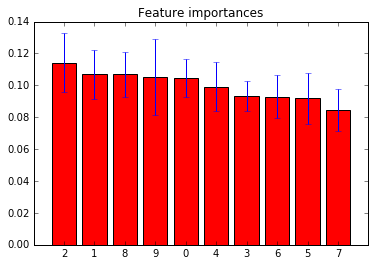

In [20]:
#2 classes classification
print('\n2 CLASSES CLASSIFICATION\n')
X_2_few, Y_2_few, columns_2_few = prepare_features_multi_remove('Data/players_with features_no_nan_only_num_values.csv',2)
cross_validation(X_2_few, Y_2_few, cv_param=20)

print('')
features_2 = plot_feature_importances(X_2_few,Y_2_few,columns_2_few)

#9 classes classification
print('\n9 CLASSES CLASSIFICATION\n')
X_9_few, Y_9_few, columns_9_few = prepare_features_multi_remove('Data/players_with features_no_nan_only_num_values.csv',9)
cross_validation(X_9_few, Y_9_few, cv_param=20)

print('')
features_2_few = plot_feature_importances(X_9_few,Y_9_few,columns_9_few)

There are no surprises in these results, which behaved as we predicted. The overall accuracy even went down a bit, as some a the features we removed might have provided the slightiest of helps in order to obtain the classification we had before. We will not comment a lot on those results, as they exhibit the same behaviour as the previous ones. Just note that the significance of every features increased, but it is only due to the fact that we are only considering 10 features now on. Every feature appears to be as ineffective as another to obtain the results we have, with some of the features we added containing the referee bias towards a player yielding a small improvement in prediction, but nothing very meaningful still. Note however that there seems to be less variance in this case.


## 1.6. Conclusion
The experiment done in determining the skin colour of the player from the dataset we were given seems to be quite unsuccessful. We were not able to either create or find in our data a feature that would systematically discrimate the players between the colour of their skin. This is reassuring in the fact that the skin colour of a player does not seems to differentiate the performance, as well as the behaviour of the referee does not seem to change significantly. 

# 2. Unsupervised Learning

We now try another of performing this classification by using *unsupervised* Machine Learning. In this problem, we do not have any label for the training corresponding to the skin colour, and we try to seperate the data into two distinct clusters. However this separation is completely *unsupervised* and we have **no guanrantee that the split will be done between black and white people**, because we do not tell the algorithm on which criteria the split between the clusters should be done.

The features we use are the same as previously, where we only keep the best 10 features

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data = X_2_few

kmeans = KMeans(n_clusters=2, init = 'k-means++', random_state=0).fit(data)

predictions = kmeans.labels_

print("Silhouette score : {s}".format(s=silhouette_score(data, kmeans.labels_)))

# people belonging to cluster 0
clust0 = Y_2[kmeans.labels_ == 0]
print("Percentage of black people in cluster 0 : {s}".format(s=clust0.mean()))

# people belonging to cluster 1
clust1 = Y_2[kmeans.labels_ == 1]
print("Percentage of black people in cluster 1 : {s}".format(s=clust1.mean()))

# We choose the cluster assignement (either to Black or White) in order to maximize the correctness
correctness = np.mean([int(np.abs(diff) < 0.5) for diff in kmeans.labels_ - Y_2])
if correctness > 0.5:
    labels = kmeans.labels_
else:
    labels = 1 - kmeans.labels_

# we want the corectness to be either close to 1 (clust 1 : skin_colour 1, clust 0 : skin_colour 0)
# or close to 0 (opposite distribution)
correctness = np.mean([int(np.abs(diff) < 0.5) for diff in labels - Y_2])
print("Correctness : {c}".format(c=correctness))

Silhouette score : 0.5350414488161211
Percentage of black people in cluster 0 : 0.2545871559633027
Percentage of black people in cluster 1 : 0.22685185185185186
Correctness : 0.5736196319018405


We performed the clustering with the *KMeans algorithm* using the *speedup method KMeans++ for initialisation*. We used the ten most relevant features that we identified in the previous part. The metric we use in order to describe whether the two clusters are well separated is the *silhouette score*, a scalar ranging between -1 and 1, which describes how similiar an object is to its own cluster compared to the other clusters. A result 1 would indicate a perfect match of the object to its cluster. Here, the resulting *silhouette score is 0.56*, which not so bad. Thus the two clusters are pretty well separated from one another. 

We then computed the correctness of the clustering, ie the percentage of people that are in the right cluster, considering the best labelling for the two clusters (either cluster 1 -> black and 0 -> white or the other way around). We get that nearly 60% of people are in the correct cluster. However given that the two populations are quite unbalanced, we should look at the percentage of black people in the two clusters and see if wee observe a significant difference. We observe that the clusters contain respectively 23.7% and 22.2% of black people. Thus the two obtained population do not make any difference between white and black people.

We now try to remove some more features in order to obtain better results.

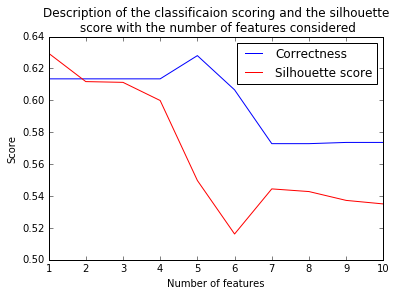

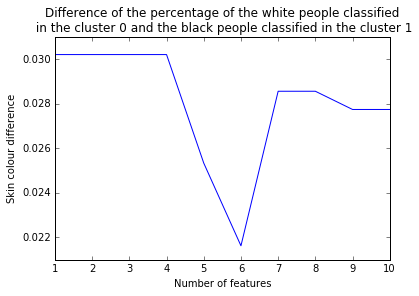

In [22]:
correctnessTab = []
silhouetteTab = []
skinDifference = []

for nbFeatures in range(X_2_few.shape[1]):
    X = X_2_few.iloc[:,0:nbFeatures+1]
    
    kmeans = KMeans(n_clusters=2, init = 'k-means++', random_state=0).fit(X)
    silhouetteTab.append(silhouette_score(X, kmeans.labels_))
    
    correctness = np.mean([int(np.abs(diff) < 0.5) for diff in kmeans.labels_ - Y_2])
    if correctness > 0.5:
        labels = kmeans.labels_
    else:
        labels = 1 - kmeans.labels_
    
    clust0 = Y_2_few[labels == 0]
    
    clust1 = Y_2_few[labels == 1]
    
    skinDifference.append(np.abs(clust0.mean() - clust1.mean()))
    
    correctness = np.mean([int(np.abs(diff) < 0.5) for diff in labels - Y_2])
    correctnessTab.append(correctness)
    
plt.figure()
plt.plot(list(range(1, 11)), correctnessTab, label="Correctness")
plt.hold(True)
plt.plot(list(range(1, 11)), silhouetteTab, 'r', label="Silhouette score")
plt.xlabel("Number of features")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title('Description of the classificaion scoring and the silhouette\n score with the number of features considered')

plt.figure()
plt.plot(list(range(1, 11)), skinDifference)
plt.xlabel("Number of features")
plt.ylabel("Skin colour difference")
plt.title('Difference of the percentage of the white people classified\n in the cluster 0 and the black people classified in the cluster 1')

We observe that having only a few features increasing the classification accuracy. However, it still remains very bad in terms of skin colour classification : the difference of black people ratio between the two populations is always less than 2 points. Thus we cannot find some particular features that separate white and black people into two populations. Also note that the sihouette score is not so bad, which means that the clusters are quite well separated. We see that this does not mean that the clustering separates well black and white people.